Processing: video_263.avi
Skipping video due to invalid scale values (xy_max == xy_min)
Processing: video_156_flip.avi
Processing: video_114.avi
Skipping video due to invalid scale values (xy_max == xy_min)
Processing: video_186_flip.avi
Processing: video_95_flip.avi
Processing: video_288_flip.avi
Processing: video_41.avi
Processing: video_262_flip.avi
Processing: video_92.avi
Processing: video_0.avi
Processing: video_83.avi
Processing: video_275.avi
Processing: video_57_flip.avi
Processing: video_140_flip.avi
Processing: video_69_flip.avi
Processing: video_54.avi
Processing: video_37.avi
Processing: video_74.avi
Processing: video_136_flip.avi
Processing: video_58_flip.avi
Skipping video due to invalid scale values (xy_max == xy_min)
Processing: video_119_flip.avi
Processing: video_91.avi
Processing: video_135_flip.avi
Skipping video due to invalid scale values (xy_max == xy_min)
Processing: video_286.avi
Processing: video_258_flip.avi
Processing: video_26.avi
Processing: video_281.avi

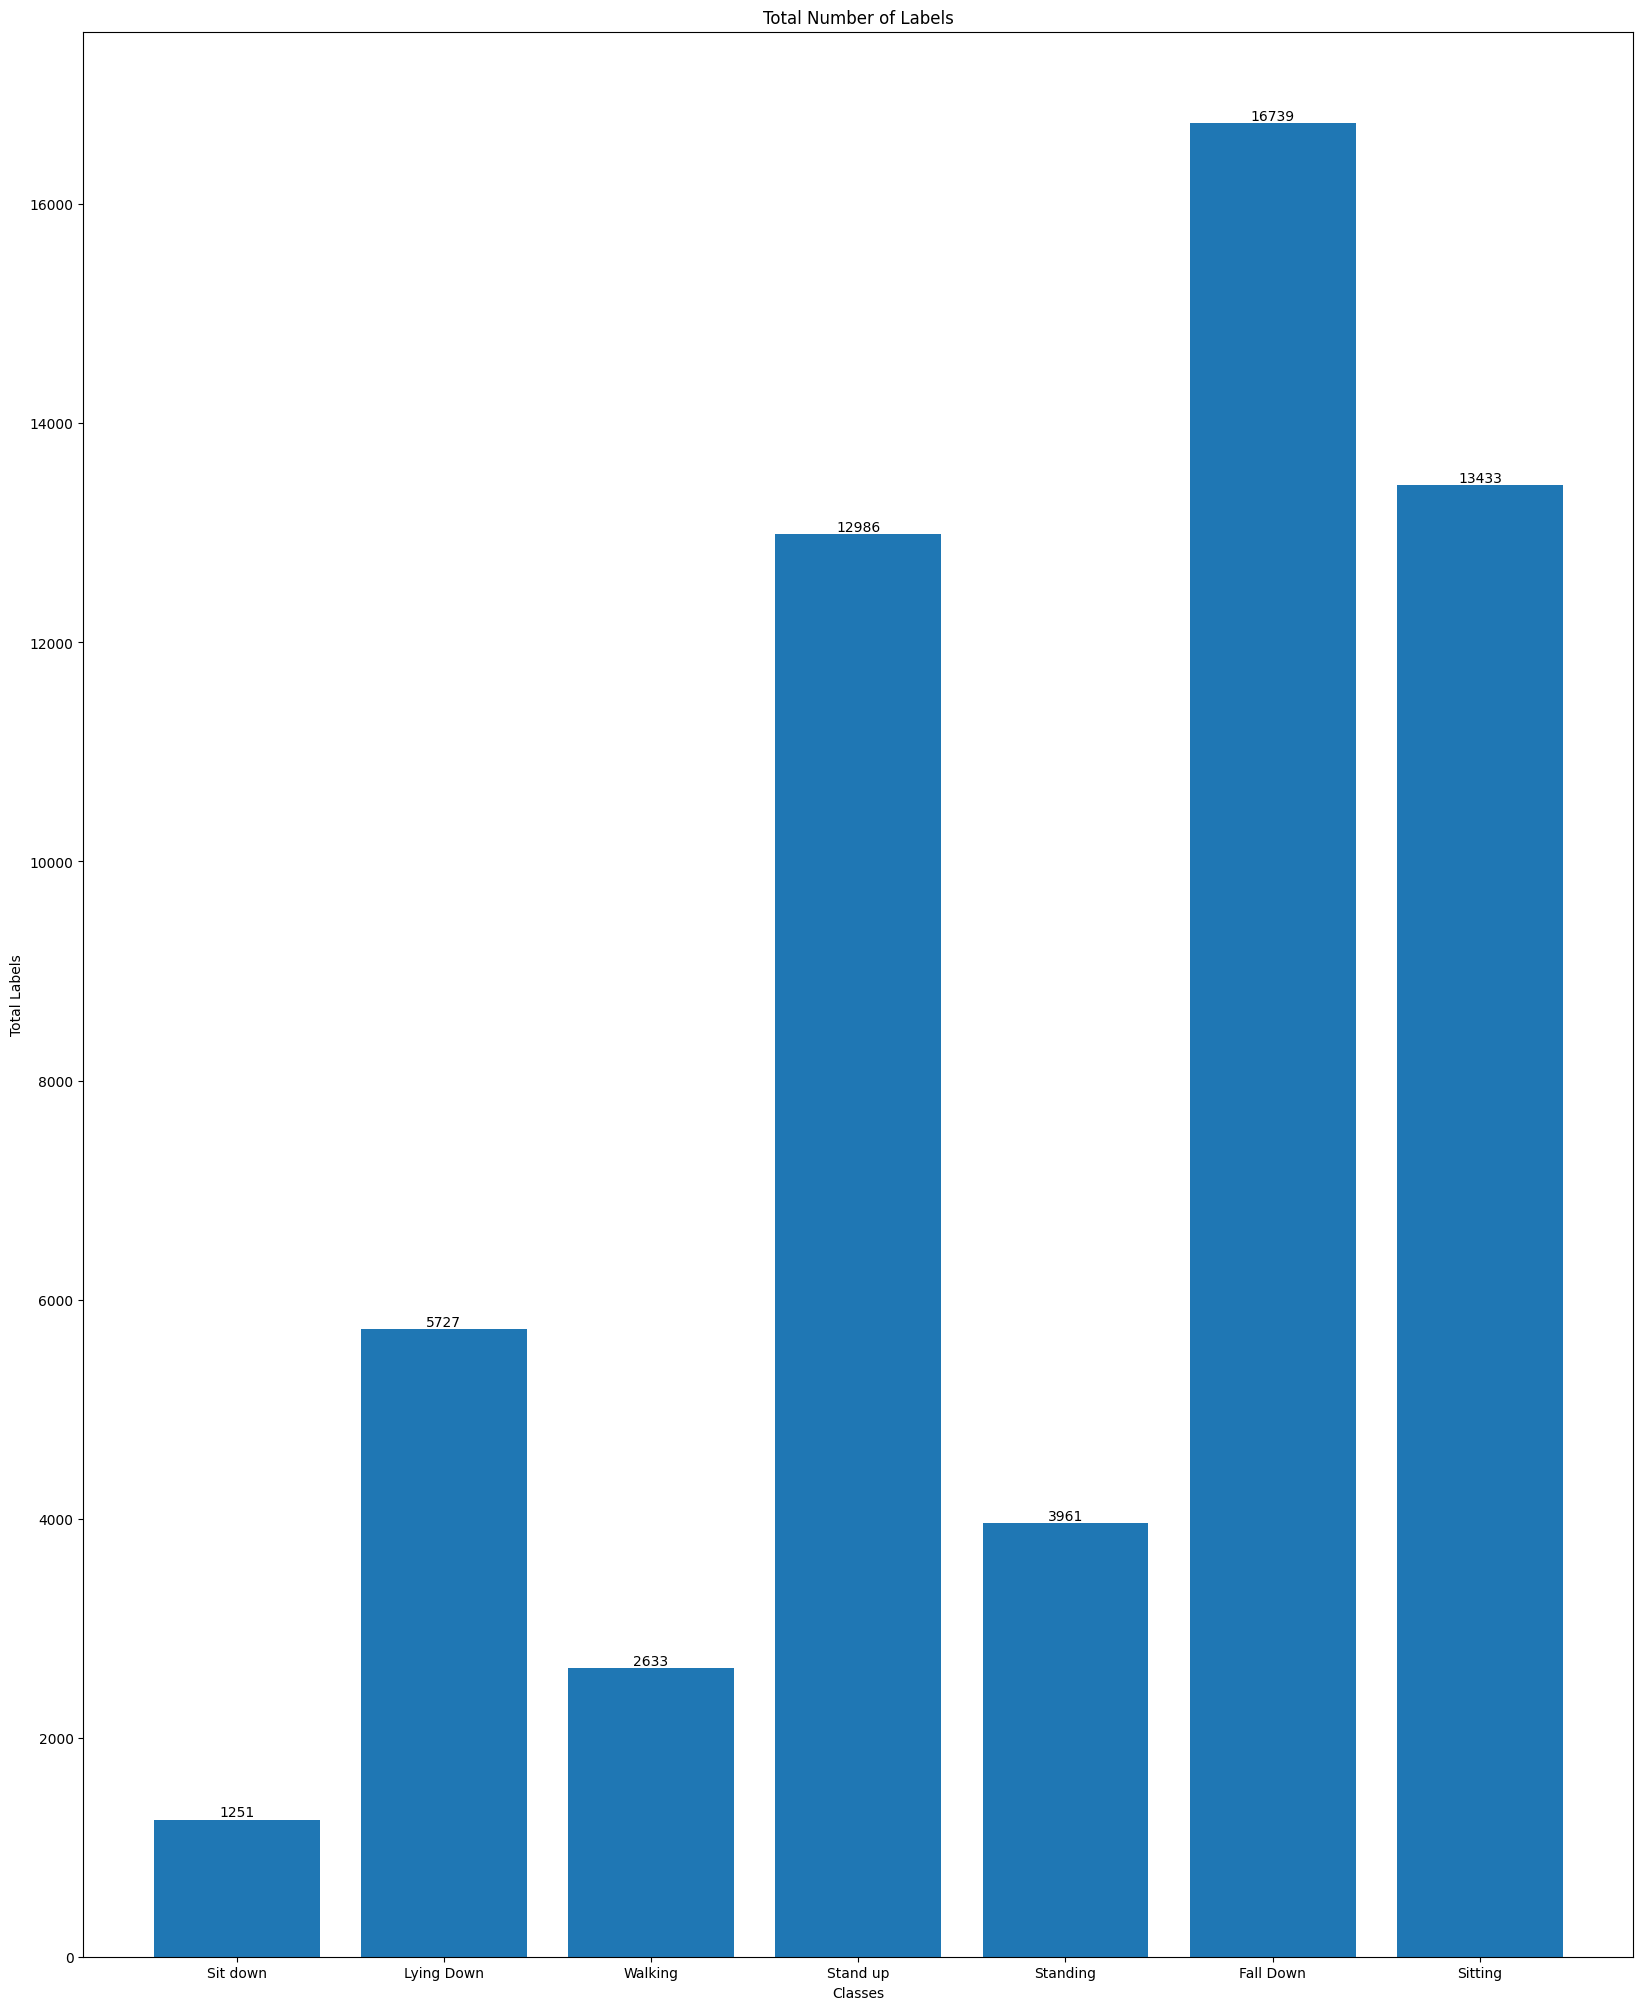

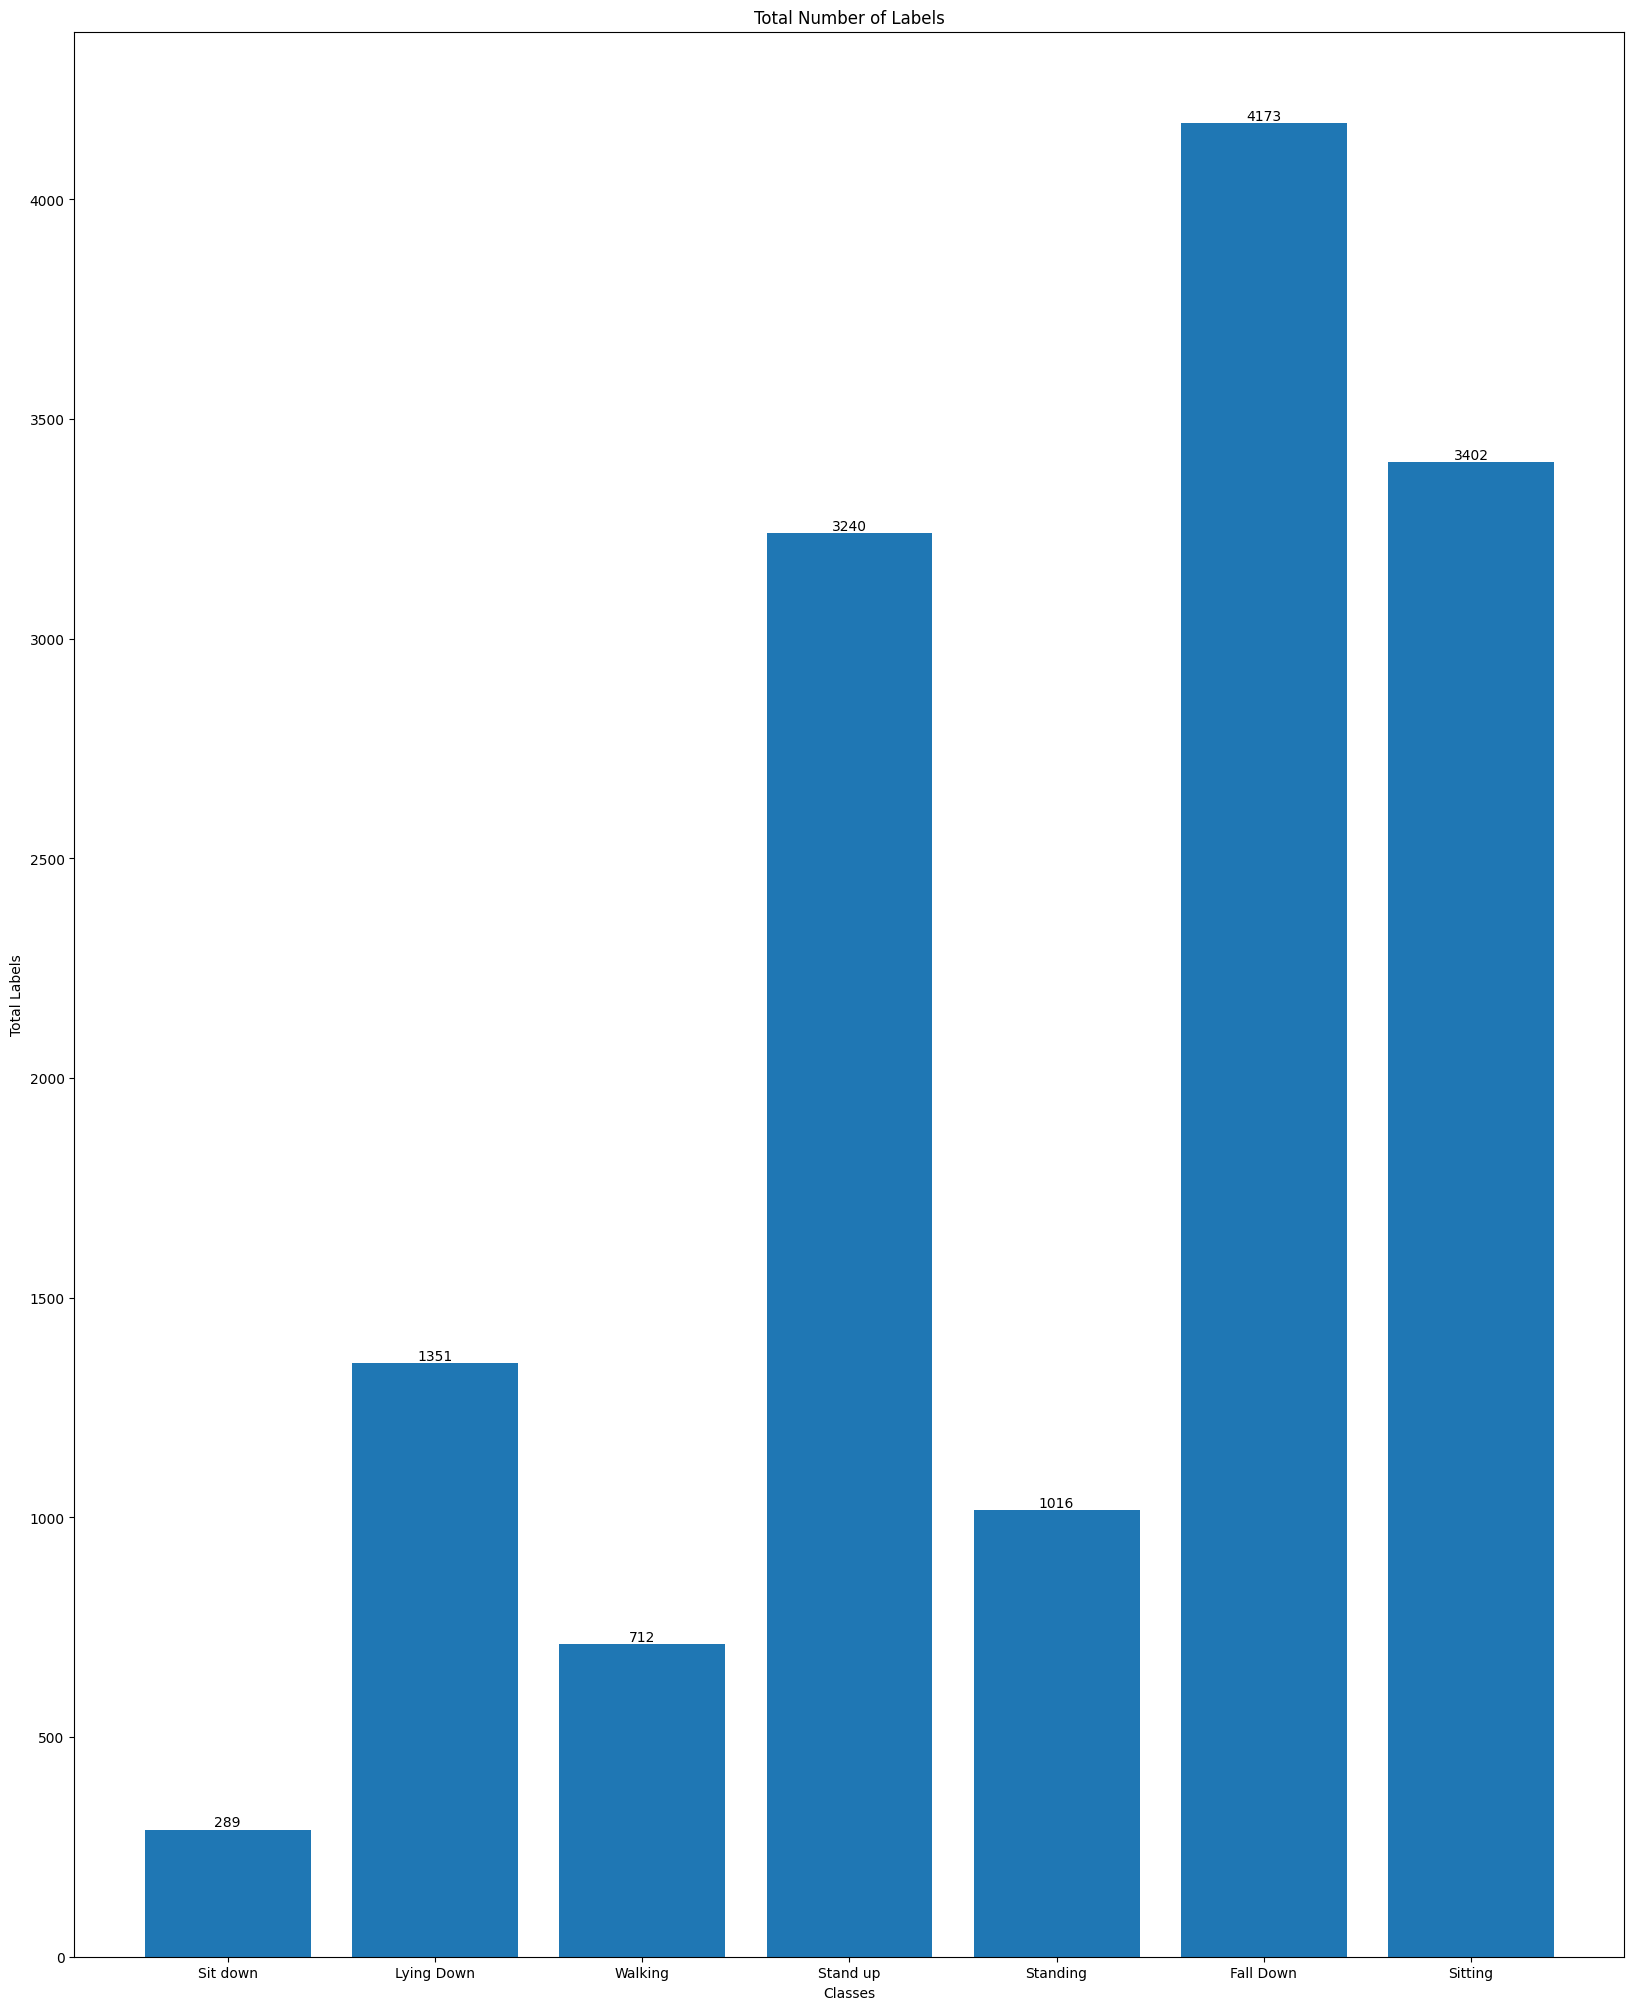

Processing complete.


In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Class names and body keypoints
class_names = ['Fall Down', 'Lying Down', 'Sit down', 'Sitting', 'Stand up', 'Standing', 'Walking']
main_parts = ['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_s', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_s',
              'left_hip_x', 'left_hip_y', 'left_hip_s', 'right_hip_x', 'right_hip_y', 'right_hip_s',
              'left_knee_x', 'left_knee_y', 'left_knee_s', 'right_knee_x', 'right_knee_y', 'right_knee_s']
main_idx_parts = [5, 6, 11, 12, 13, 14]

# Paths
csv_pose_file = 'data/output_pose_and_score.csv'
save_path_train = 'data/train.pkl'
save_path_test = 'data/test.pkl'

# Params
smooth_labels_step = 8
n_frames = 30
skip_frame = 1

def scale_pose(xy):
    if xy.ndim == 2:
        xy = np.expand_dims(xy, 0)
    xy_min = np.nanmin(xy, axis=1)
    xy_max = np.nanmax(xy, axis=1)

    zero_division_mask = (xy_max - xy_min) == 0
    if np.any(zero_division_mask):
        print(f"Skipping video due to invalid scale values")
        return None

    for i in range(xy.shape[0]):
        xy[i] = ((xy[i] - xy_min[i]) / (xy_max[i] - xy_min[i])) * 2 - 1
    return xy.squeeze()

def seq_label_smoothing(labels, max_step=10):
    steps = 0
    remain_step = 0
    target_label = 0
    active_label = 0
    start_change = 0
    max_val = np.max(labels)
    min_val = np.min(labels)
    
    for i in range(labels.shape[0]):
        if remain_step > 0:
            if i >= start_change:
                labels[i][active_label] = max_val * remain_step / steps
                labels[i][target_label] = max_val * (steps - remain_step) / steps if max_val * (steps - remain_step) / steps else min_val
                remain_step -= 1
            continue
        
        diff_index = np.where(np.argmax(labels[i:i+max_step], axis=1) - np.argmax(labels[i]) != 0)[0]
        if len(diff_index) > 0:
            start_change = i + remain_step // 2
            steps = diff_index[0]
            remain_step = steps
            target_label = np.argmax(labels[i + remain_step])
            active_label = np.argmax(labels[i])
    return labels

def plot_total_label(labels_set, cols):
    label = np.argmax(labels_set, axis=1)
    values = np.zeros((len(class_names),), dtype=int)
    cols = list(cols)

    label_idx = [cols.index(i) if i in cols else None for i in range(len(class_names))]
    for i in range(len(values)):
        values[i] = sum(label == label_idx[i]) if label_idx[i] is not None else 0

    plt.figure(figsize=(20, 25))
    plt.bar(class_names, values)
    plt.title('Total Number of Labels')
    plt.xlabel('Classes')
    plt.ylabel('Total Labels')
    for i in range(len(values)):
        plt.annotate(str(values[i]), xy=(i, values[i]), ha='center', va='bottom')
    plt.show()

# Load and preprocess data
annot = pd.read_csv(csv_pose_file)

# Remove NaN rows
idx = annot.iloc[:, 2:-1][main_parts].isna().sum(1) > 0
idx = np.where(idx)[0]
annot = annot.drop(idx)

# One-Hot Encode Labels
label_onehot = pd.get_dummies(annot['label'])
annot = annot.drop('label', axis=1).join(label_onehot)
cols = label_onehot.columns.values

# Initialize empty feature and label sets
feature_set = np.empty((0, n_frames, 17, 3))
labels_set = np.empty((0, len(cols)))

# Process videos
vid_list = annot['video'].unique()
for vid in vid_list:
    print(f'Processing: {vid}')
    data = annot[annot['video'] == vid].reset_index(drop=True).drop(columns='video')

    # Apply label smoothing
    esp = 0.1
    data[cols] = data[cols] * (1 - esp) + (1 - data[cols]) * esp / (len(cols) - 1)
    data[cols] = seq_label_smoothing(data[cols].values, smooth_labels_step)

    frames = data['frame'].values
    frames_set = []
    fs = [0]
    for i in range(1, len(frames)):
        if frames[i] < frames[i-1] + 10:
            fs.append(i)
        else:
            frames_set.append(fs)
            fs = [i]
    frames_set.append(fs)

    for fs in frames_set:
        xys = data.iloc[fs, 1:-len(cols)].values.reshape(-1, 17, 3)
        scaled_xys = scale_pose(xys[:, :, :2])
        
        if scaled_xys is None:
            break

        scr = xys[:, :, -1].copy()
        scr[:, main_idx_parts] = np.minimum(scr[:, main_idx_parts] * 1.5, 1.0)
        scr = scr.mean(1)

        lb = data.iloc[fs, -len(cols):].values * scr[:, None]

        for i in range(xys.shape[0] - n_frames):
            feature_set = np.append(feature_set, xys[i:i+n_frames][None, ...], axis=0)
            labels_set = np.append(labels_set, lb[i:i+n_frames].mean(0)[None, ...], axis=0)

# Balance dataset
label_indices = np.argmax(labels_set, axis=1)
unique_labels, label_counts = np.unique(label_indices, return_counts=True)
min_count = np.min(label_counts)

balanced_features = []
balanced_labels = []

for label in unique_labels:
    label_mask = (label_indices == label)
    class_features = feature_set[label_mask]
    class_labels = labels_set[label_mask]
    
    indices = np.random.choice(len(class_features), min_count, replace=False)
    balanced_features.append(class_features[indices])
    balanced_labels.append(class_labels[indices])

feature_set = np.concatenate(balanced_features, axis=0)
labels_set = np.concatenate(balanced_labels, axis=0)

# Split and save data
X_train, X_test, y_train, y_test = train_test_split(feature_set, labels_set, test_size=0.2, random_state=0)

with open(save_path_train, 'wb') as f:
    pickle.dump((X_train, y_train), f)

with open(save_path_test, 'wb') as f:
    pickle.dump((X_test, y_test), f)

# Plot results
plot_total_label(y_train, cols)
plot_total_label(y_test, cols)

print('Processing complete.')